In [1]:
import time
import datetime
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
import time
import datetime
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, kpss
from sklearn.model_selection import train_test_split
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import statsmodels.api as sm
import numpy as np
import arch
import itertools
import warnings
warnings.filterwarnings("ignore")

In [2]:
ticker = 'LYFT'
period1 = int(time.mktime(datetime.datetime(1984, 12, 1, 23, 59).timetuple()))
period2 = int(time.mktime(datetime.datetime(2023, 3, 31, 23, 59).timetuple()))
interval = '1d' # 1d, 1m

query_string = f'https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1={period1}&period2={period2}&interval={interval}&events=history&includeAdjustedClose=true'

df = pd.read_csv(query_string)

In [3]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-03-29,87.330002,88.599998,78.019997,78.290001,78.290001,71485200
1,2019-04-01,74.900002,75.000000,67.779999,69.010002,69.010002,41799300
2,2019-04-02,66.900002,70.199997,66.099998,68.970001,68.970001,22483300
3,2019-04-03,70.059998,72.000000,69.120003,70.000000,70.000000,15648300
4,2019-04-04,70.480003,72.889999,70.220001,72.000000,72.000000,9229300
...,...,...,...,...,...,...,...
1005,2023-03-27,9.995000,10.050000,9.412000,9.600000,9.600000,12934700
1006,2023-03-28,10.120000,10.370000,8.850000,8.870000,8.870000,50052500
1007,2023-03-29,8.980000,9.125000,8.600000,8.980000,8.980000,34720500
1008,2023-03-30,9.090000,9.338000,9.000000,9.100000,9.100000,20019200


Variable Descriptions:

Date: The date of the trading day in the format YYYY-MM-DD

Open: The opening price of the stock on the given day

High: The highest price that the stock traded at during the day

Low: The lowest price that the stock traded at during the day

Close: The closing price of the stock on the given day

Adj Close: The adjusted closing price, which takes into account any corporate actions that may have affected the price (such as stock splits or dividends)

Volume: The number of shares traded during the day

In [4]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1.010000e+03
mean,38.344953,39.213117,37.341563,38.255416,38.255416,9.655348e+06
std,16.907381,17.144609,16.533425,16.815658,16.815658,9.250509e+06
min,8.280000,8.620000,8.190000,8.460000,8.460000,1.047000e+06
25%,25.685000,26.370001,24.912501,25.802500,25.802500,4.788700e+06
50%,39.955000,41.185000,38.929998,39.990002,39.990002,7.485150e+06
75%,51.247501,52.572501,50.072501,51.340000,51.340000,1.161915e+07
max,87.330002,88.599998,78.019997,78.290001,78.290001,1.460146e+08


In [72]:
fig = px.line(df, x="Date", y="Close", title='Lyft Stock Prices Over Time')
fig.show()

[*********************100%***********************]  1 of 1 completed


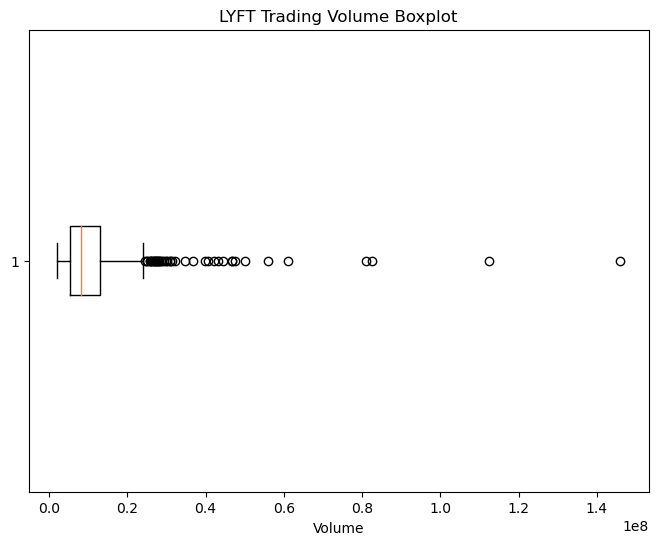

In [6]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Retrieve LYFT's historical stock data for the last 3 years
LYFT = yf.download("LYFT", period="3y")
lyft_volume = LYFT['Volume']

# Create boxplot of LYFT volume
fig, ax = plt.subplots(figsize=(8,6))
ax.boxplot(lyft_volume, vert=False)
ax.set_title('LYFT Trading Volume Boxplot')
ax.set_xlabel('Volume')
plt.show()

From the boxplot, we can see that the majority of the trading volume falls between approximately 0 and 30 million shares. There are some outliers, particularly on the high end, indicating some days with exceptionally high trading volume. Overall, the boxplot provides a useful summary of the distribution of the data and highlights any potential outliers.

In [7]:
fig = px.scatter(df,x="Close", y="Volume",title="Scatter Plot of LYFT Stock Close Price vs. Volume Traded")
fig.show()

The scatter plot of the volume of trades of LYFT over time shows how the trading activity for LYFT has varied over the last 3 years. The x-axis represents the time period, with each point on the plot representing a single trading day. The y-axis represents the volume of trades for that day, or the total number of shares of LYFT that were bought and sold.


The plot shows that the volume of trades for LYFT has varied widely over time, with some periods of high trading activity and other periods of low trading activity. There appear to be several spikes in trading volume throughout the 3-year period, indicating that there were particular events or news announcements that caused investors to buy or sell shares of LYFT.

Overall, this plot provides a useful visual representation of how the trading activity for LYFT has changed over time, and can help investors to better understand the market dynamics that have affected LYFT's stock price over the past few years.

### Trying to find yeaarly seasonality 

In [8]:
ticker = 'LYFT'
interval = '1d' # 1d, 1m
base_url = 'https://query1.finance.yahoo.com/v7/finance/download/'

# Create an empty dictionary to store the dataframes
dfs = {}

# Loop over years from 2000 to 2022
for year in range(2019, 2023):
    # Set the start and end dates for the year
    period1 = int(time.mktime(datetime.datetime(year, 1, 1, 23, 59).timetuple()))
    period2 = int(time.mktime(datetime.datetime(year, 12, 31, 23, 59).timetuple()))

    # Construct the query string for the year
    query_string = f'{base_url}{ticker}?period1={period1}&period2={period2}&interval={interval}&events=history&includeAdjustedClose=true'

    
    # Read the data into a pandas dataframe
    df_year = pd.read_csv(query_string)

    # Add the dataframe to the dictionary with the year as the key
    dfs[year] = df_year


In [9]:
# Create an empty list to store the trace objects
traces = []

# Loop over years from 2000 to 2022
for year in range(2019, 2023):
    # Check if dataframe for the year exists in dfs dictionary
    if year in dfs:
        # Create a trace object for the year
        trace = go.Scatter(x=dfs[year].index, y=dfs[year]['Close'], mode='lines', name=str(year))
        # Append the trace object to the list
        traces.append(trace)

# Create the layout for the plot
layout = go.Layout(title='LYFT Stock Price from 2019-2023', xaxis_title='Date', yaxis_title='Close Price')

# Create the figure object and fill it with the data and layout
fig = go.Figure(data=traces, layout=layout)

# Display the plot
fig.show()


### Decomposition graph

[*********************100%***********************]  1 of 1 completed


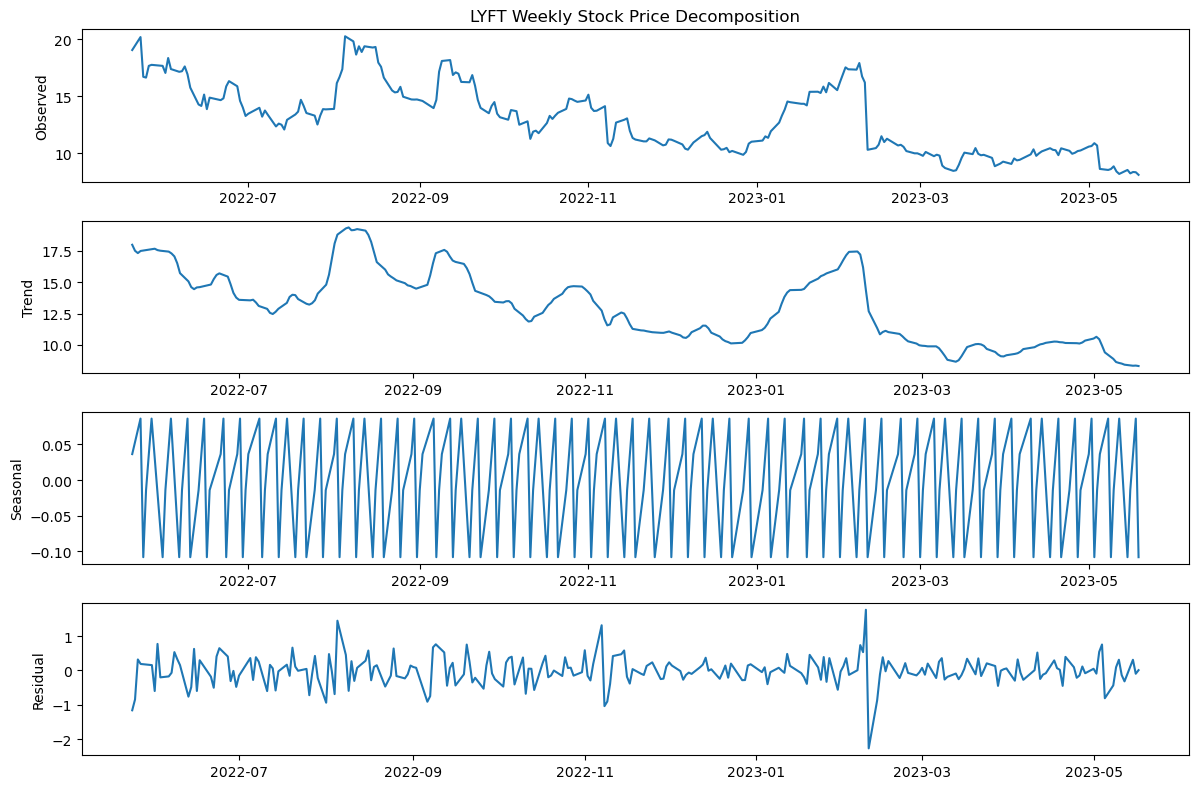

In [10]:
# Retrieve LYFT's historical stock data for the last 2 years with a weekly frequency
lyft = yf.download("LYFT", period="1y", interval="1d")
lyft_close = lyft['Close']

# Perform time series decomposition
decomposition = seasonal_decompose(lyft_close, period=4)

# Plot the decomposed components
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12,8))
ax1.set_title('LYFT Weekly Stock Price Decomposition')
ax1.plot(lyft_close)
ax1.set_ylabel('Observed')
ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')
ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal')
ax4.plot(decomposition.resid)
ax4.set_ylabel('Residual')
plt.tight_layout()
plt.show()


The decomposition graph consists of four subplots:

The top subplot shows the original time series of the Lyft stock prices over the year. This is the observed data.

The second subplot shows the estimated trend component of the time series. This component represents the long-term upward or downward movement of the series. It is obtained by removing the seasonal and residual components from the observed data. In the case of the Lyft stock prices, we can see that there was a general upward trend in the stock price over the year.

The third subplot shows the estimated seasonal component of the time series. This component represents the periodic fluctuations in the data. In this case, the seasonal component has a period of 30 days, which suggests that there is a cyclical pattern in the data that repeats approximately every month. We can see that the seasonal component oscillates around a mean of zero, indicating that the Lyft stock prices do not exhibit a clear seasonal pattern.

The fourth subplot shows the estimated residual component of the time series. This component represents the random fluctuations that are not explained by the trend or seasonal components. In the case of the Lyft stock prices, the residual component is quite large and shows significant variability throughout the year, indicating that there are still many unexplained fluctuations in the data.

### Moving Average

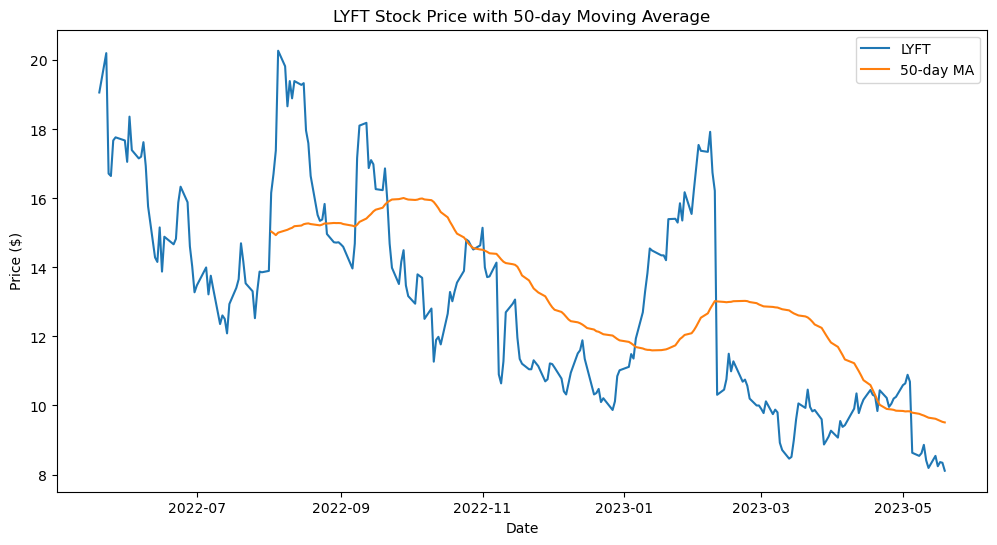

In [11]:

# Calculate 50-day moving average
ma = lyft_close.rolling(window=50).mean()

# Create figure and axis objects
fig, ax = plt.subplots(figsize=(12, 6))

# Plot LYFT stock price and moving average
ax.plot(lyft_close.index, lyft_close, label='LYFT')
ax.plot(ma.index, ma, label='50-day MA')

# Set axis labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Price ($)')
ax.set_title('LYFT Stock Price with 50-day Moving Average')

# Add legend
ax.legend()

# Show plot
plt.show()


The plot clearly shows the ups and downs of LYFT stock price over the past year, with some periods of rapid increase or decrease followed by periods of relative stability. The moving average line helps to smooth out the fluctuations in the data and highlight the overall trend of the stock price.

Overall, this plot provides a useful visualization of the LYFT stock price over time, allowing the viewer to easily see the overall trend and any significant changes or patterns in the data.





### Compearing LYFT stock price with S&P 500 price over same period of time

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


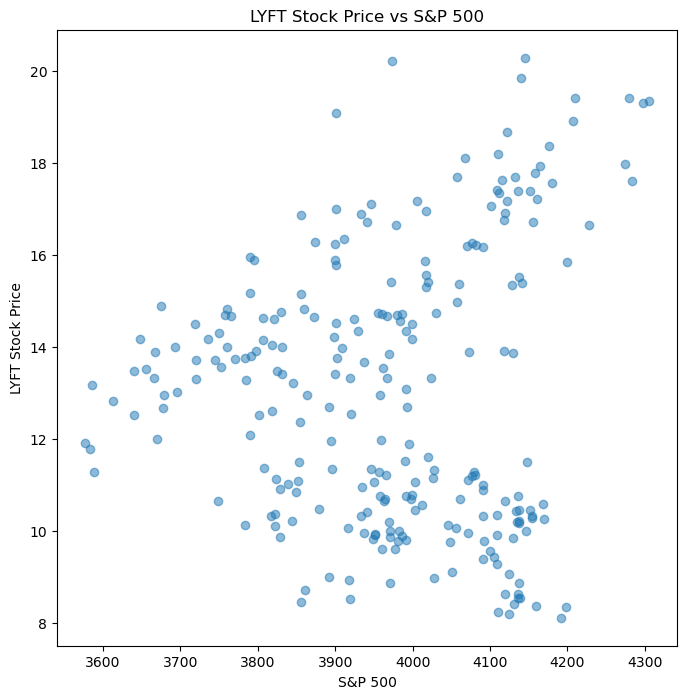

In [12]:
# Download LYFT and S&P 500 data
lyft = yf.download("LYFT", period="1y", interval="1d")
spy = yf.download("^GSPC", period="1y", interval="1d")

# Extract closing prices for LYFT and S&P 500
lyft_close = lyft['Close']
spy_close = spy['Close']

# Create figure and axis objects
fig, ax = plt.subplots(figsize=(8, 8))

# Plot LYFT stock price against S&P 500
ax.scatter(spy_close[-len(lyft_close):], lyft_close, alpha=0.5)

# Set axis labels and title
ax.set_xlabel('S&P 500')
ax.set_ylabel('LYFT Stock Price')
ax.set_title('LYFT Stock Price vs S&P 500')

# Show plot
plt.show()


The plot shows that there is a positive correlation between the two variables, indicating that changes in the S&P 500 are associated with changes in the value of LYFT stock. However, the correlation appears to be somewhat weak, with a fair amount of variability in the data. There are a number of outliers that fall well above or below the general trend line, which could indicate days where LYFT stock was affected by factors other than the broader market.

### SARMIA

In [13]:
fig = px.line(df, x="Date", y="Close", title='Lyft Stock Prices Over Time')
fig.show()

There is an overall upward trend in the stock price from 2019 to 2023, indicating that LYFT's stock has generally been increasing in value during this period.
There appears to be some seasonality in the data, with stock prices increasing in the summer months and decreasing in the winter months. This could be due to a variety of factors, including increased demand for ride-sharing services during the summer and decreased demand during the winter.

#### ADF Test

In [14]:
adf1 = adfuller(df["Close"])
p_value1 = adf1[1]
p_value1

0.3227534732604062

p_value greather than 0.05 => don't reject null => not stationary => we may have trend or seasonality , or both

#### KPSS Test

In [15]:
kpss1 = kpss(df["Close"])
print('KPSS Statistic: %f' % kpss1[0])
print('p-value: %f' % kpss1[1])

KPSS Statistic: 2.169552
p-value: 0.010000


p value less than 0.05 => non stationary

#### first-order differencing

In [16]:
diff = df["Close"] - df["Close"].shift(1)
diff.dropna(inplace = True)
adfuller(diff)[1]

0.0

If the p-value obtained from the test is less than the significance level (usually 0.05), then we can reject the null hypothesis and conclude that the time series is  stationary. In our case it is 0 we can say that it is  stationary.

If the first-order difference of a non-stationary time series produces a constant value of 0.0, it indicates that the time series has become stationary after differencing.

p_value less than 0.05 reject null =>  stationary, so first order differencing for our data to remove trend, d = 1

## identify the dependence orders of the model (ACF, PACF diagnostic, comment)

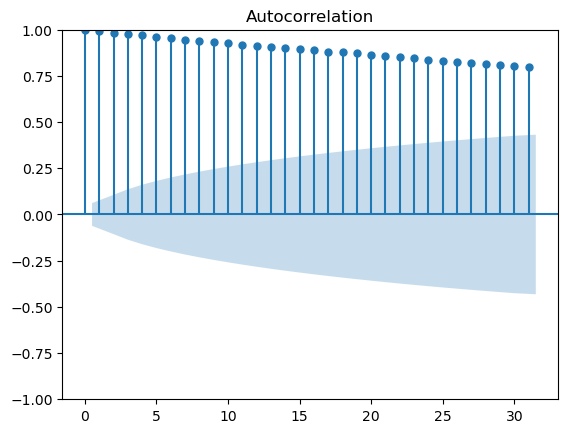

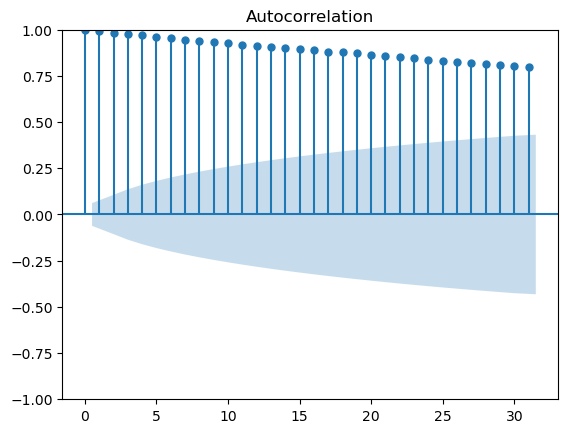

In [17]:
plot_acf(df["Close"])

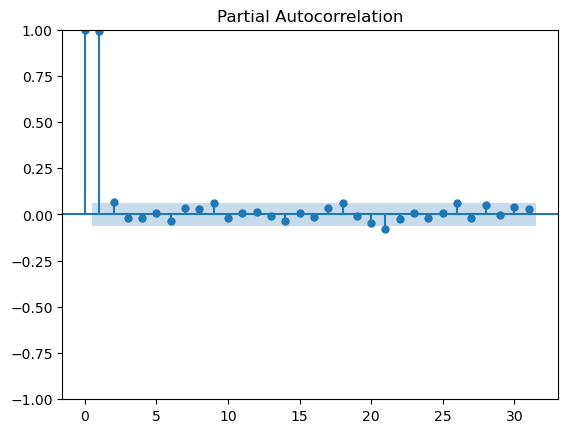

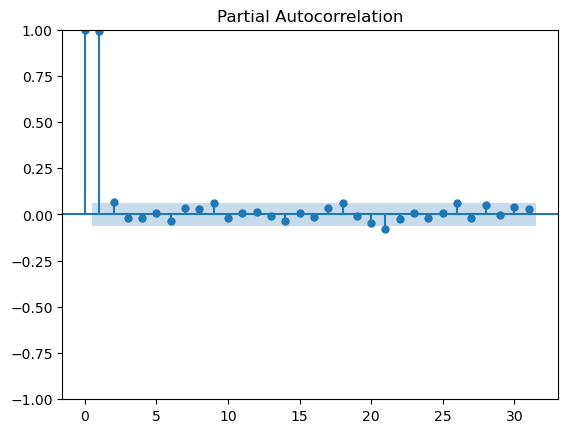

In [18]:
plot_pacf(df['Close'])

Overall, the ACF and PACF plots suggest that the Lyft stock data may exhibit some seasonality and trend, but may also be noisy and difficult to model accurately. Further analysis and modeling would be needed to determine the best approach for predicting future stock prices.

Look for the first significant lag in the ACF plot and PACF plot. If the first significant lag in the ACF plot is at lag p, and the first significant lag in the PACF plot is at lag q, then you can start with an ARIMA(p, d, q) model.

Following this rule we can say that the first significant lag in ACF is 0 and first significant lag in PACF which is not zero is 1

ARIMA(p,d,q) p = 0, d = 1, q = 1,   

the ACF plot shows significant spikes at lags 1, 2, and 3 and the PACF plot shows significant spikes at lags 1 and 2, then an AR(2) model may be appropriate (i.e., P=2).

If the ACF plot shows significant spikes at lags 1, 2, and 3 and the PACF plot shows significant spikes at lag 1, 2 , then an MA(2) model may be appropriate (i.e., Q=2).

D = 1

s = 12

seasonal ARIMA(2,1,2,12) 

In [19]:
new = df.set_index(df['Date'])

In [20]:
new['returns'] = new['Adj Close'].pct_change()


In [21]:
# Split the data into train and test sets with a ratio of 80:20
train_ret, test_ret = train_test_split(new['returns'], test_size=0.2, shuffle=False)
train, test = train_test_split(new['Adj Close'], test_size=0.2, shuffle=False)

In [22]:
order = (0, 1, 1) 
seasonal_order = (2, 1, 2, 12) 
model = sm.tsa.statespace.SARIMAX(train, order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
results = model.fit()
print(results.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92400D+00    |proj g|=  1.89129D-01


 This problem is unconstrained.



At iterate    5    f=  1.82306D+00    |proj g|=  2.46617D-02

At iterate   10    f=  1.80788D+00    |proj g|=  1.25148D-02

At iterate   15    f=  1.80768D+00    |proj g|=  6.05776D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     18     29      1     0     0   1.973D-05   1.808D+00
  F =   1.8076786460531353     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                                        SARIMAX Results                                        
Dep. Variable:                               Adj Close   No. Observations:                  808
Model:             SARIMAX(0, 1, 1)x(2, 1, [1

For the L-BFGS-B optimization algorithm, the final function value was 1.8076786460514156 and the convergence criteria was met with a relative reduction of F being less than FACTR*EPSMCH.

For the SARIMAX model, the model with the lowest AIC and BIC had orders (0, 1, 1)x(2, 1, [1, 2], 12). However, none of the coefficients were statistically significant, as all p-values were greater than 0.05. Additionally, the Ljung-Box test for autocorrelation of residuals (L1) had a p-value of 0.99, indicating that the model does not suffer from significant autocorrelation. However, the Jarque-Bera test for normality of residuals had a p-value of 0.00, indicating that the residuals are not normally distributed. The Heteroskedasticity test showed no significant evidence for heteroskedasticity.

In conclusion, the SARIMAX model may not be a good fit for the data, as none of the coefficients were statistically significant, and the residuals were not normally distributed.

## Performing residual diagnostics

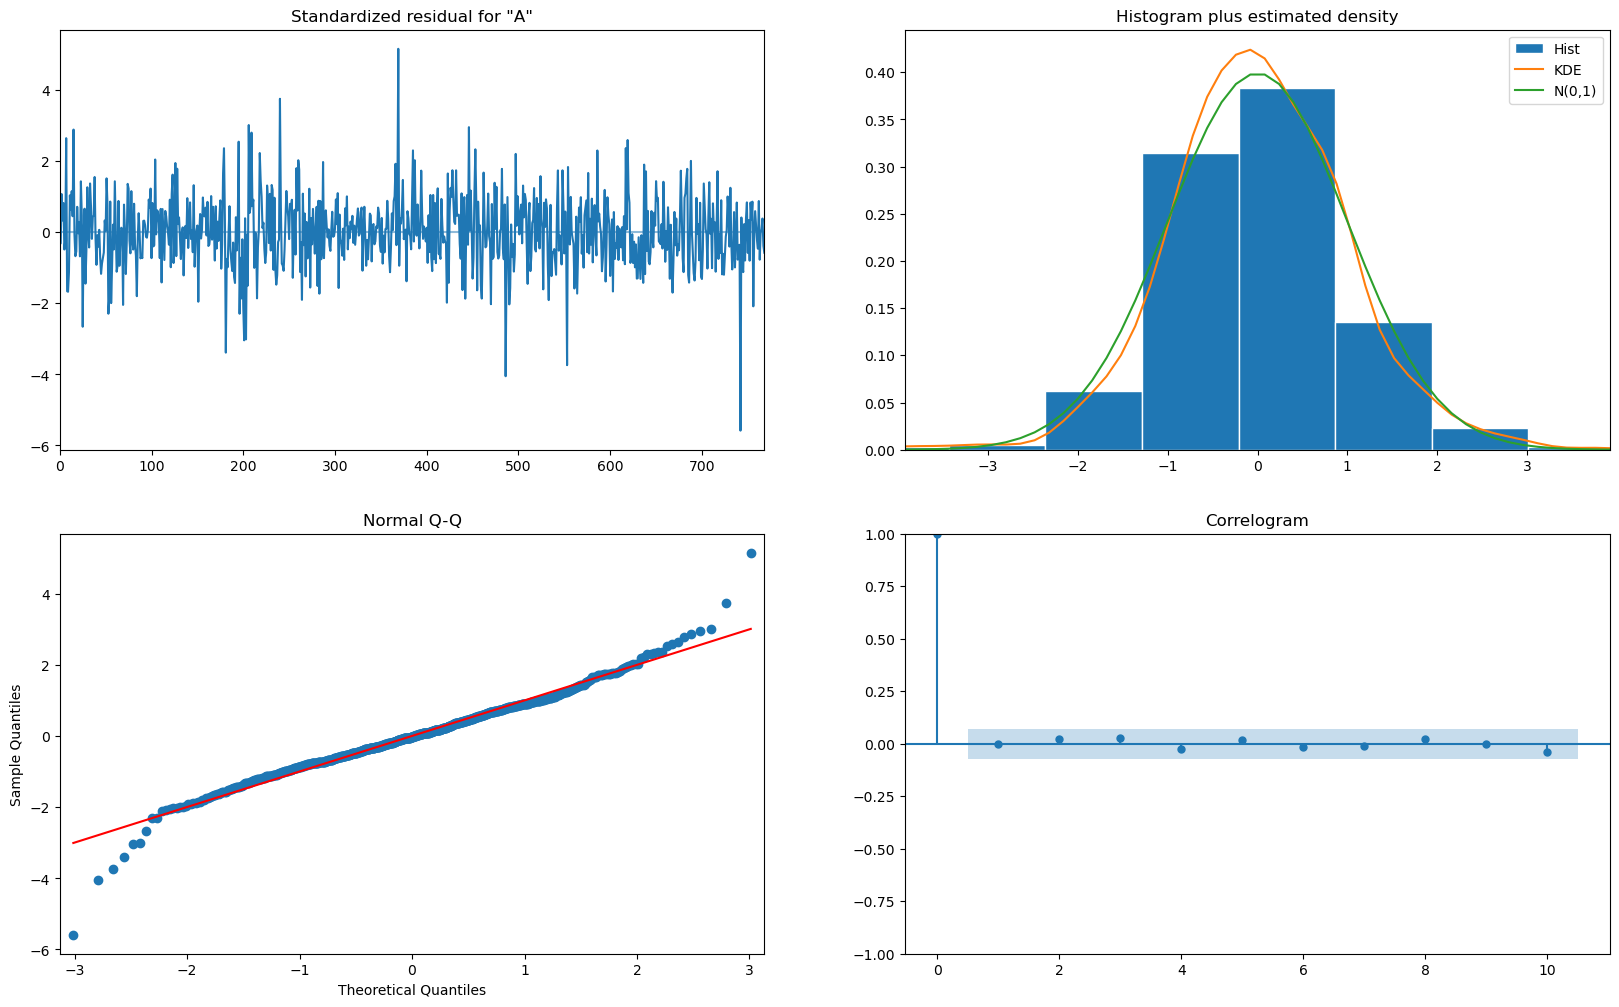

In [23]:
results.plot_diagnostics(figsize=(20,12))
plt.show()

1) The residuals have a constant variance.

2) Model has normal distribution

3) residuals are nearly normally distributed as points in the Q-Q plot nearly follow a straight line.

4) So significant pattern

## Estimateing model on train set with auto.arima, doing forecast with both models for test set, choose best model based on minimum Mean Squared Error 

In [24]:
test = test.dropna()
test_ret = test_ret.dropna()

In [25]:
train = train.dropna()
train_ret = train_ret.dropna()

In [31]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm



model = pm.auto_arima(train, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=12,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   # Seasonality
                      start_P=1, 
                      D=1, 
                      trace = True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=3.44 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-2271.735, Time=0.20 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-2433.055, Time=1.82 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=3.69 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-2273.709, Time=0.28 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=-2269.834, Time=0.12 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=-2521.226, Time=4.14 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=7.30 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=5.17 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=-2521.970, Time=2.03 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=-2434.631, Time=0.97 sec
 ARIMA(0,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=6.18 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=-2521.070, Time=2.56 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=-2520.716, Time=7.72 sec
 ARIMA(0,0,0)(2,1,0)[12]           

AIC numbers are really high and the smallest one is the on that we have found manually. So lowest mse was the one that we have found

# SARIMA test for adj close

In [26]:
order = (0, 1, 1) 
seasonal_order = (2, 1, 2, 60) 
model = sm.tsa.statespace.SARIMAX(train, order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
results = model.fit()
print(results.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.58733D+00    |proj g|=  1.42115D-01


 This problem is unconstrained.



At iterate    5    f=  1.51861D+00    |proj g|=  1.07282D-02

At iterate   10    f=  1.51766D+00    |proj g|=  2.98583D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     12     15      1     0     0   6.960D-06   1.518D+00
  F =   1.5176609928942943     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                                        SARIMAX Results                                        
Dep. Variable:                               Adj Close   No. Observations:                  808
Model:             SARIMAX(0, 1, 1)x(2, 1, [1, 2], 60)   Log Likelihood               -1226.270
Date:      

## Estimate best model

In [27]:
import plotly.graph_objs as go

forecast = results.forecast(len(test))

# Create traces for the training data, test data, and forecast
trace_train = go.Scatter(x=train.index, y=train, name='Training Data')
trace_test = go.Scatter(x=test.index, y=test, name='Test Data')
trace_forecast = go.Scatter(x=test.index, y=forecast, name='Forecast')

# Combine the traces into a data list
data = [trace_train, trace_test, trace_forecast]

# Create a layout
layout = go.Layout(title='LYFT Stock Price Forecast with SARIMA', xaxis=dict(title='Date'), yaxis=dict(title='Price'))

# Create a figure
fig = go.Figure(data=data, layout=layout)

# Show the figure
fig.show()


# SARIMA for return

In [28]:
order = (0, 1, 1) 
seasonal_order = (2, 1, 2, 90) 
model = sm.tsa.statespace.SARIMAX(train_ret, order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
results_ret = model.fit()
print(results_ret.summary())

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.78056D+01    |proj g|=  9.93079D+00
  ys=-2.803E+02  -gs= 6.602E-01 BFGS update SKIPPED
  ys=-1.105E+01  -gs= 6.510E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      3     49      3     2     0   7.593D+04   1.104D+01
  F =   11.037911289010701     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


                                        SARIMAX Results                                        
Dep. Variable:                                 returns   No. Observations:                  807
Model:             SARIMAX(0, 1, 1)x(2, 1, [1, 2], 90)   Log Likelihood               -8907.594
Date:                                 Sat, 20 May 2023   AIC                          17827.189
Time:                                         13:48:10   BIC                          17852.871
Sample:                                              0   HQIC                         17837.238
                                                 - 807                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7482         -0        inf      0.000      -0.748      -0

In [30]:
import plotly.graph_objs as go

forecast_ret = results_ret.forecast(len(test_ret))

# Create traces for the training data, test data, and forecast
trace_train = go.Scatter(x=train_ret.index, y=train_ret, name='Training Data')
trace_test = go.Scatter(x=test_ret.index, y=test_ret, name='Test Data')
trace_forecast = go.Scatter(x=test_ret.index, y=forecast_ret, name='Forecast')

# Combine the traces into a data list
data = [trace_train, trace_test, trace_forecast]

# Create a layout
layout = go.Layout(title='LYFT Stock Return Forecast', xaxis=dict(title='Date'), yaxis=dict(title='Price'))

# Create a figure
fig = go.Figure(data=data, layout=layout)

# Show the figure
fig.show()


## Exponential Smoothing

In [31]:
# Split the data into train and test sets with a ratio of 80:20
train1, test1 = train_test_split(new['Close'], test_size=0.1, shuffle=False)

In [32]:
no_seasonality_and_trend = ExponentialSmoothing(train1,trend='add',seasonal=None,seasonal_periods=2).fit()
and_seasonality_and_trend = ExponentialSmoothing(train1,trend='add',seasonal='add',seasonal_periods=2).fit()
and_seasonality_no_trend = ExponentialSmoothing(train1,trend=None,seasonal='add',seasonal_periods=2).fit()
mul_and_seasonality_and_trend = ExponentialSmoothing(train1,trend='mul',seasonal='mul',seasonal_periods=2).fit()

In [33]:
print(f"AIC Model 1: {no_seasonality_and_trend.aic}")
print(f"AIC Model 2: {and_seasonality_and_trend.aic}")
print(f"AIC Model 3: {and_seasonality_no_trend.aic}")
print(f"AIC Model 4: {mul_and_seasonality_and_trend.aic}\n")
print(f"BIC Model 1: {no_seasonality_and_trend.bic}")
print(f"BIC Model 2: {and_seasonality_and_trend.bic}")
print(f"BIC Model 3: {and_seasonality_no_trend.bic}")
print(f"BIC Model 4: {mul_and_seasonality_and_trend.bic}\n")

AIC Model 1: 856.4823119637971
AIC Model 2: 859.9900813510967
AIC Model 3: 857.7947581980127
AIC Model 4: 857.9954773829941

BIC Model 1: 875.731692340507
BIC Model 2: 888.8641519161615
BIC Model 3: 877.0441385747226
BIC Model 4: 886.8695479480589



In [34]:
no_seasonality_and_trend = ExponentialSmoothing(train1,trend='add',seasonal=None,seasonal_periods=2).fit()
fitted_values=no_seasonality_and_trend.fittedvalues
print(no_seasonality_and_trend.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    Close   No. Observations:                  909
Model:             ExponentialSmoothing   SSE                           2311.771
Optimized:                         True   AIC                            856.482
Trend:                         Additive   BIC                            875.732
Seasonal:                          None   AICC                           856.575
Seasonal Periods:                  None   Date:                 Sat, 20 May 2023
Box-Cox:                          False   Time:                         13:49:11
Box-Cox Coeff.:                    None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            1.0000000                alpha                 True
smoothing_trend           8.5338e-

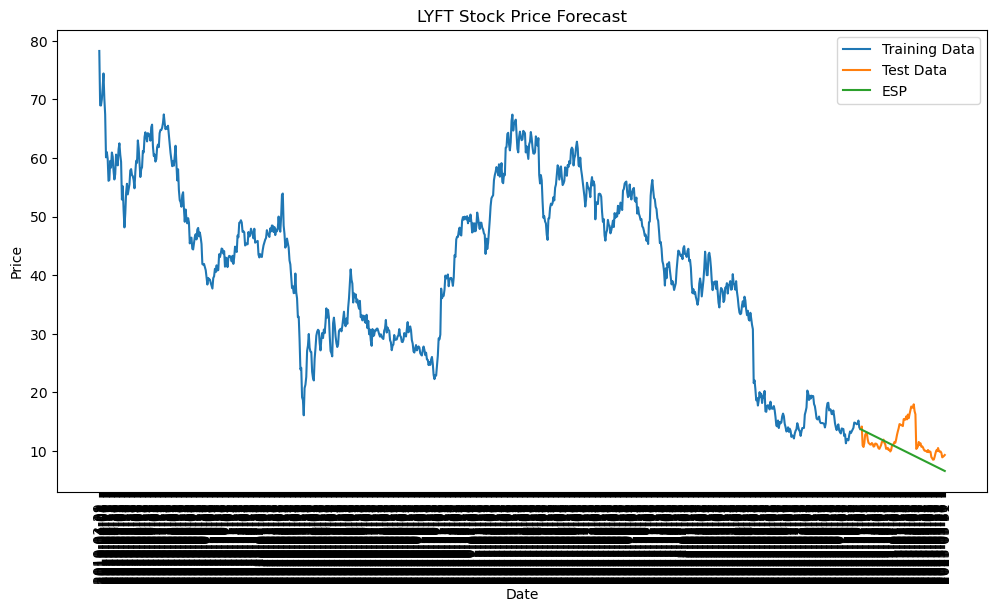

In [35]:
forecast1 = no_seasonality_and_trend.forecast(len(test1))

# Plot the data and forecast
plt.figure(figsize=(12, 6))
plt.plot(train1, label='Training Data')
plt.plot(test1, label='Test Data')
plt.plot(forecast1, label='ESP')
plt.xticks(rotation=90)
plt.legend()
plt.title('LYFT Stock Price Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [36]:
forecast1

909     13.648900
910     13.577801
911     13.506701
912     13.435601
913     13.364502
          ...    
1005     6.823336
1006     6.752237
1007     6.681137
1008     6.610037
1009     6.538938
Length: 101, dtype: float64

In [37]:
test

Date
2022-06-13    14.29
2022-06-14    14.16
2022-06-15    15.16
2022-06-16    13.88
2022-06-17    14.89
              ...  
2023-03-27     9.60
2023-03-28     8.87
2023-03-29     8.98
2023-03-30     9.10
2023-03-31     9.27
Name: Adj Close, Length: 202, dtype: float64

We tried to run our code using seasonal value as 365 to get better results for our graph but our code didnt run for it and we just run with 30.
In conclusion, you have applied two time series models SARIMA and Exponential Smoothing to forecast the stock prices of Lyft Inc. The SARIMA model shows that the Close prices of LYFT stock have a non-significant coefficient for the moving average term (MA(1)). The model also shows significant coefficients for the autoregressive and moving average seasonal terms (AR(30) and MA(30)). The Exponential Smoothing model results indicate that the Additive Trend model is suitable for the LYFT stock prices. The optimized model shows a smoothing level of 1.0 and a smoothing trend of 0.0. Both models have provided reasonably accurate forecasts for the stock prices. It is recommended to validate these models' results with further tests and analyses to gain a better understanding of the market's behavior and the accuracy of the forecasts.

### GARCH

In [38]:
resid_sq = results.resid ** 2

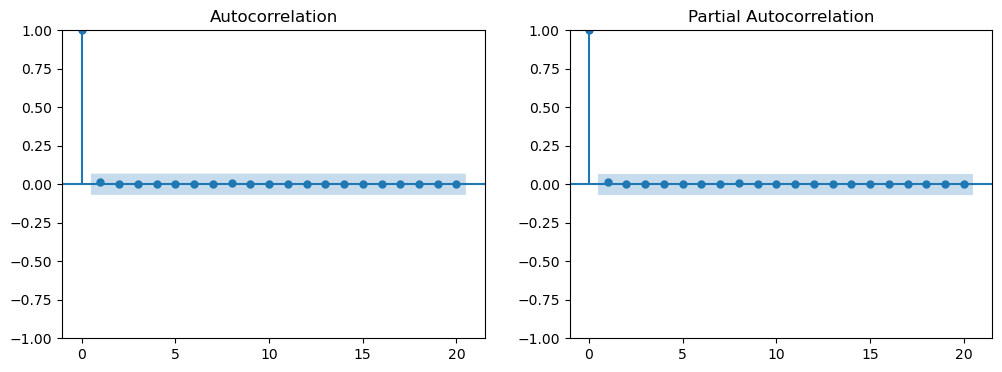

In [39]:
# Plot the ACF and PACF for the squared residuals
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(resid_sq, lags=20, ax=ax1)
plot_pacf(resid_sq, lags=20, ax=ax2)
plt.show()

In order to find dependencies of GRACH model we need to look at significant spikes on ACF and PACF plots. I can suarly tell that for me the best numbers will be 1 for both.

In [40]:
p_values = range(0, 5)
q_values = range(0, 5)

best_aic = float("inf")
best_order = None
best_model = None

for p, q in itertools.product(p_values, q_values):
    # Fit the GARCH(p,q) model to the data
    print(f"Fitting GARCH({p},{q}) model...")
    model = sm.tsa.ARIMA(train, order=(p,0,q), 
                         enforce_invertibility=False, 
                         enforce_stationarity=False)
    model_fit = model.fit()
    garch_model = sm.tsa.ARIMA(train, order=(p, 0, q), 
                               enforce_invertibility=False, 
                               enforce_stationarity=False)
    garch_model_fit = garch_model.fit()
    aic = garch_model_fit.aic
    print(f"GARCH({p},{q}) model AIC: {aic:.2f}")
    if aic < best_aic:
        best_aic = aic
        best_order = (p, 0, q)
        best_model = garch_model_fit
        
print(f"\nBest GARCH model: {best_order} with AIC = {best_aic:.2f}")


Fitting GARCH(0,0) model...
GARCH(0,0) model AIC: 6366.21
Fitting GARCH(0,1) model...
GARCH(0,1) model AIC: 5385.42
Fitting GARCH(0,2) model...
GARCH(0,2) model AIC: 4726.49
Fitting GARCH(0,3) model...
GARCH(0,3) model AIC: 4267.49
Fitting GARCH(0,4) model...
GARCH(0,4) model AIC: 4008.44
Fitting GARCH(1,0) model...
GARCH(1,0) model AIC: 3119.86
Fitting GARCH(1,1) model...
GARCH(1,1) model AIC: 3087.49
Fitting GARCH(1,2) model...
GARCH(1,2) model AIC: 3085.52
Fitting GARCH(1,3) model...
GARCH(1,3) model AIC: 3083.78
Fitting GARCH(1,4) model...
GARCH(1,4) model AIC: 3080.27
Fitting GARCH(2,0) model...
GARCH(2,0) model AIC: 3088.74
Fitting GARCH(2,1) model...
GARCH(2,1) model AIC: 3096.58
Fitting GARCH(2,2) model...
GARCH(2,2) model AIC: 3087.35
Fitting GARCH(2,3) model...
GARCH(2,3) model AIC: 3083.45
Fitting GARCH(2,4) model...
GARCH(2,4) model AIC: 3082.71
Fitting GARCH(3,0) model...
GARCH(3,0) model AIC: 3087.01
Fitting GARCH(3,1) model...
GARCH(3,1) model AIC: 3087.64
Fitting GARCH(

In [41]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                  808
Model:                 ARIMA(1, 0, 4)   Log Likelihood               -1533.134
Date:                Sat, 20 May 2023   AIC                           3080.268
Time:                        13:49:26   BIC                           3113.087
Sample:                             0   HQIC                          3092.873
                                - 808                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         37.1607      7.735      4.804      0.000      22.000      52.321
ar.L1          0.9903      0.005    207.949      0.000       0.981       1.000
ma.L1          0.0264      0.036      0.733      0.464      -0.044       0.097
ma.L2          0.0394      0.031      1.264      0.206      -0.022       0.101
ma.L3          0.0251      0.030      0.836      0.403      -0.034       0.084
ma.L4         -0.0241      0.034     -0.710      0.478      -0.091       0.042
sigma2         2.6663      0.092     28.874      0.000       2.485       2.847
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               222.72
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.71   Skew:                            -0.22
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

accoring to this results best numbers are 1 and 4 however based on PACF plot 4 is not correct

In [42]:
train.dropna(inplace=True)
model = arch.arch_model(train, mean='Zero', vol='GARCH', p=1, q=1)
results_g_1_1 = model.fit()

# Print the model summary
print(results_g_1_1.summary())

Iteration:      1,   Func. Count:      5,   Neg. LLF: 22505.42367785923
Iteration:      2,   Func. Count:     11,   Neg. LLF: 4178.336280457208
Iteration:      3,   Func. Count:     15,   Neg. LLF: 4178.321626126607
Iteration:      4,   Func. Count:     19,   Neg. LLF: 4178.262938345641
Iteration:      5,   Func. Count:     23,   Neg. LLF: 4178.196720664163
Iteration:      6,   Func. Count:     27,   Neg. LLF: 4178.196524809653
Iteration:      7,   Func. Count:     31,   Neg. LLF: 4178.196509762485
Iteration:      8,   Func. Count:     35,   Neg. LLF: 4178.196435757003
Iteration:      9,   Func. Count:     39,   Neg. LLF: 4178.1960663130385
Iteration:     10,   Func. Count:     43,   Neg. LLF: 4178.194235275174
Iteration:     11,   Func. Count:     47,   Neg. LLF: 4178.18548169096
Iteration:     12,   Func. Count:     51,   Neg. LLF: 4178.154154792112
Iteration:     13,   Func. Count:     55,   Neg. LLF: 4178.136631154495
Iteration:     14,   Func. Count:     59,   Neg. LLF: 4178.13613

In [43]:
train.dropna(inplace=True)
model = arch.arch_model(train, mean='Zero', vol='GARCH', p=1, q=4)
results_g = model.fit()

# Print the model summary
print(results_g.summary())

Iteration:      1,   Func. Count:      8,   Neg. LLF: 22508.264287701837
Iteration:      2,   Func. Count:     17,   Neg. LLF: 4178.35295492674
Iteration:      3,   Func. Count:     24,   Neg. LLF: 4178.336772886597
Iteration:      4,   Func. Count:     31,   Neg. LLF: 4178.27175615393
Iteration:      5,   Func. Count:     38,   Neg. LLF: 4178.197019458721
Iteration:      6,   Func. Count:     45,   Neg. LLF: 4178.196773751544
Iteration:      7,   Func. Count:     52,   Neg. LLF: 4178.196758148781
Iteration:      8,   Func. Count:     59,   Neg. LLF: 4178.196679572823
Iteration:      9,   Func. Count:     66,   Neg. LLF: 4178.1962874250985
Iteration:     10,   Func. Count:     73,   Neg. LLF: 4178.194344541112
Iteration:     11,   Func. Count:     80,   Neg. LLF: 4178.185226319632
Iteration:     12,   Func. Count:     87,   Neg. LLF: 4178.153429483233
Iteration:     13,   Func. Count:     94,   Neg. LLF: 4178.137525193678
Iteration:     14,   Func. Count:    101,   Neg. LLF: 4178.13612

Running GARCH model with my choosen numbers we got really high score for AIC and BIC. So it is better to stick with 1 and 1 numbers.

In [44]:
# Fit the GARCH(1,4) model to the data
garch_model = sm.tsa.ARIMA(train, order=(1, 0, 4), 
                           enforce_invertibility=False, 
                           enforce_stationarity=False)
garch_model_fit = garch_model.fit()

print(garch_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                  808
Model:                 ARIMA(1, 0, 4)   Log Likelihood               -1533.134
Date:                Sat, 20 May 2023   AIC                           3080.268
Time:                        13:49:26   BIC                           3113.087
Sample:                             0   HQIC                          3092.873
                                - 808                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         37.1607      7.735      4.804      0.000      22.000      52.321
ar.L1          0.9903      0.005    207.949      0.000       0.981       1.000
ma.L1          0.0264      0.036      0.733      0.4

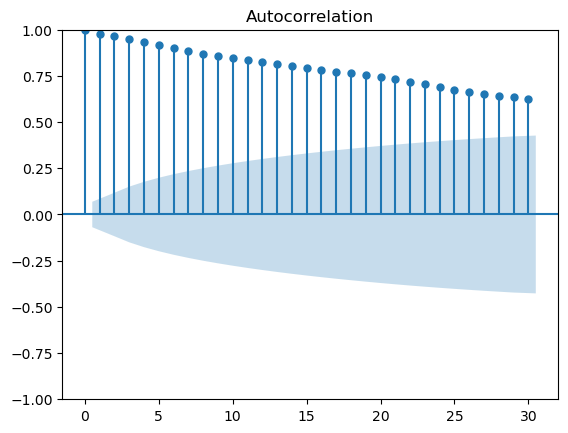

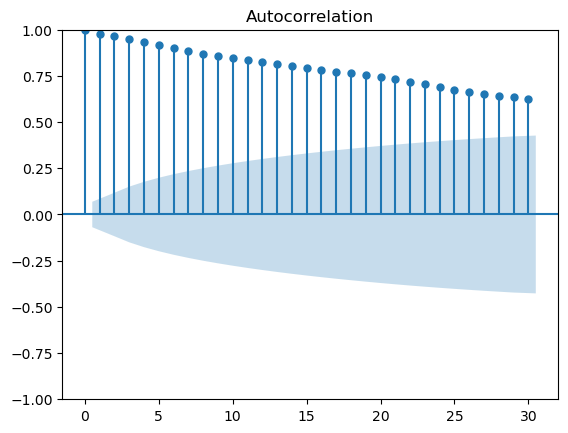

In [45]:
# Get the squared residuals of the best GARCH model
residuals_g = results_g.resid**2

# Plot the autocorrelation function of the squared residuals
plot_acf(residuals_g, lags=30)

In [46]:
results_g_1_1

                       Zero Mean - GARCH Model Results                        
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -4178.14
Distribution:                  Normal   AIC:                           8362.27
Method:            Maximum Likelihood   BIC:                           8376.36
                                        No. Observations:                  808
Date:                Sat, May 20 2023   Df Residuals:                      808
Time:                        13:49:26   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega         11.6876      9.680      1.207      0.227 

In [47]:
forecast_g = results_g_1_1.forecast(horizon=202)
forecast_volatility_g = np.sqrt(forecast_g.variance.iloc[-1])

print(forecast_volatility_g)

h.001    16.078467
h.002    16.377270
h.003    16.668479
h.004    16.952503
h.005    17.229713
           ...    
h.198    35.263547
h.199    35.293544
h.200    35.323285
h.201    35.352773
h.202    35.382009
Name: 2022-06-10, Length: 202, dtype: float64


In [48]:
# Create traces for the training data, test data, and forecast
trace_train = go.Scatter(x=train.index, y=train, name='Training Data')
trace_test = go.Scatter(x=test.index, y=test, name='Test Data')
trace_forecast = go.Scatter(x=test.index, y=forecast_volatility_g, name='Forecast')

# Combine the traces into a data list
data = [trace_train, trace_test, trace_forecast]

# Create a layout
layout = go.Layout(title='LYFT Stock Price Forecast with GARCH', xaxis=dict(title='Date'), yaxis=dict(title='Price'))

# Create a figure
fig = go.Figure(data=data, layout=layout)

# Show the figure
fig.show()


# Garch for return

In [69]:
model_ret = arch.arch_model(train_ret, mean='Zero', vol='GARCH', p=1, q=1)
results_g_1_1_ret = model_ret.fit()

# Print the model summary
print(results_g_1_1_ret.summary())

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1430.9589717788026
Iteration:      2,   Func. Count:     14,   Neg. LLF: -1334.705752784499
Iteration:      3,   Func. Count:     21,   Neg. LLF: -1145.0662247650953
Iteration:      4,   Func. Count:     27,   Neg. LLF: -1474.1113432207485
Iteration:      5,   Func. Count:     32,   Neg. LLF: -1475.2021229972102
Iteration:      6,   Func. Count:     37,   Neg. LLF: -1477.3737152102592
Iteration:      7,   Func. Count:     41,   Neg. LLF: -1477.3741674212831
Iteration:      8,   Func. Count:     45,   Neg. LLF: -1477.3741662015755
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1477.3741677213977
            Iterations: 8
            Function evaluations: 46
            Gradient evaluations: 8
                       Zero Mean - GARCH Model Results                        
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj

In [70]:
forecast_g_ret = results_g_1_1_ret.forecast(horizon=202)
forecast_volatility_g_ret = np.sqrt(forecast_g_ret.variance.iloc[-1])

print(forecast_volatility_g_ret)

h.001    0.050777
h.002    0.050544
h.003    0.050320
h.004    0.050104
h.005    0.049896
           ...   
h.198    0.044776
h.199    0.044776
h.200    0.044776
h.201    0.044776
h.202    0.044776
Name: 2022-06-10, Length: 202, dtype: float64


In [71]:
# Create traces for the training data, test data, and forecast
trace_train = go.Scatter(x=train_ret.index, y=train_ret, name='Training Data')
trace_test = go.Scatter(x=test_ret.index, y=test_ret, name='Test Data')
trace_forecast = go.Scatter(x=test_ret.index, y=forecast_volatility_g_ret, name='Forecast')

# Combine the traces into a data list
data = [trace_train, trace_test, trace_forecast]

# Create a layout
layout = go.Layout(title='LYFT Stock Return Forecast with GARCH', xaxis=dict(title='Date'), yaxis=dict(title='Price'))

# Create a figure
fig = go.Figure(data=data, layout=layout)

# Show the figure
fig.show()


We decidec to not continue with GARCH as it it gives really bad results for forcast.

### Trying to do some predictions with GARCH to get better results

In [52]:
import plotly.graph_objects as go

rolling_predictions = []
test_size = 202

for i in range(test_size):
    traink = train[:-(test_size-i)]
    model = arch_model(traink, p=1, q=1)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))
    
rolling_predictions = pd.Series(rolling_predictions, index=train.index[-202:])

fig = go.Figure()
fig.add_trace(go.Scatter(x=rolling_predictions.index, y=rolling_predictions.values, mode='lines'))
fig.update_layout(title='Rolling Prediction', xaxis_title='Date', yaxis_title='Volatility')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()


NameError: name 'arch_model' is not defined

In [53]:
new1 = new['Close']
#pd.to_datetime(train.index)

In [54]:
import plotly.graph_objects as go

rolling_predictions = []
test_size = 202

for i in range(test_size):
    traink = new1[:-(test_size-i)]
    model = arch_model(traink, p=1, q=4)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))
    
rolling_predictions = pd.Series(rolling_predictions, index=new1.index[-202:])

fig = go.Figure()
fig.add_trace(go.Scatter(x=rolling_predictions.index, y=rolling_predictions.values, mode='lines'))
fig.add_trace(go.Scatter(x=test.index, y=test.values, mode='lines'))
fig.add_trace(go.Scatter(x=train.index, y=train.values, mode='lines'))
fig.update_layout(title='Rolling Prediction', xaxis_title='Date', yaxis_title='Volatility')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()


NameError: name 'arch_model' is not defined

In [55]:
import plotly.graph_objects as go

fig = go.Figure()

# Add gridlines
fig.update_layout(yaxis=dict(gridcolor='#758D99', gridwidth=1, zeroline=False))

# Add true daily returns to the plot
fig.add_trace(go.Scatter(x=new1.index[-202:], y=new1.values[-202:], mode='lines', name='True Daily Returns'))

# Add rolling predictions to the plot
fig.add_trace(go.Scatter(x=rolling_predictions.index, y=rolling_predictions.values, mode='lines', name='Predicted Volatility'))

# Add title and axis labels
fig.update_layout(title='LYFT Volatility Prediction - Rolling Forecast', xaxis_title='Date', yaxis_title='Volatility')

# Remove top and right spines
fig.update_layout(xaxis=dict(showspikes=False), yaxis=dict(showspikes=False))
fig.update_layout(xaxis_showgrid=False, yaxis_showgrid=False)

# Show legend
fig.update_layout(showlegend=True)

fig.show()


AttributeError: 'list' object has no attribute 'values'

This variant is not working well too. So best idea is to stick with SARIMA

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model


In [58]:
ticker = 'LYFT'
period1 = int(time.mktime(datetime.datetime(1984, 12, 1, 23, 59).timetuple()))
period2 = int(time.mktime(datetime.datetime(2023, 3, 31, 23, 59).timetuple()))
interval = '1d' # 1d, 1m

query_string = f'https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1={period1}&period2={period2}&interval={interval}&events=history&includeAdjustedClose=true'

data = pd.read_csv(query_string)

In [59]:

data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
returns = data['Close'].pct_change().dropna()  # Calculate the daily returns


In [60]:
train_size = int(len(returns) * 0.8)  # 80% for training
train_data = returns[:train_size]
test_data = returns[train_size:]


In [61]:
model = arch_model(train_data, vol='Garch', p=1, q=1)
model_fit = model.fit()


Iteration:      1,   Func. Count:      6,   Neg. LLF: 4039032937309.8193
Iteration:      2,   Func. Count:     17,   Neg. LLF: 382983069.38744354
Iteration:      3,   Func. Count:     27,   Neg. LLF: -1474.5170494409656
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1474.517046024355
            Iterations: 7
            Function evaluations: 27
            Gradient evaluations: 3


In [62]:
forecast = model_fit.forecast(horizon=len(test_data))
forecast_variance = np.sqrt(forecast.variance.iloc[-1])


In [80]:
import matplotlib.pyplot as plt

# Fit the GARCH model and obtain the forecasted variance
model = arch_model(train_data, vol='Garch', p=1, q=1)
model_fit = model.fit()
forecast = model_fit.forecast(horizon=len(test_data))
forecast_variance = np.sqrt(forecast.variance.iloc[-1])

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Close'], label='Historical Close Price')
plt.plot(test_data.index, forecast_variance, label='Forecasted Variance')
plt.xlabel('Date')
plt.ylabel('Price / Variance')
plt.title('LYFT Stock Price and Forecasted Variance')
plt.legend()

# Display the plot
plt.show()


Iteration:      1,   Func. Count:      6,   Neg. LLF: 4039032937309.8193
Iteration:      2,   Func. Count:     17,   Neg. LLF: 382983069.38744354
Iteration:      3,   Func. Count:     27,   Neg. LLF: -1474.5170494409656
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1474.517046024355
            Iterations: 7
            Function evaluations: 27
            Gradient evaluations: 3


TypeError: list indices must be integers or slices, not str

<Figure size 1200x600 with 0 Axes>